# Experiment

### Detailed Results

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
import math
import os

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (9,5)

NUM_LOGS = 101876733
NUM_REGEX = 132
NUM_REP = 1
ns = [128]

grams_fp = ['bigram']
grams_fp_header = ['bigram', 'trigram', 'fourgram',]

INDEX_HEADERS = ['NGram', 'Num_Indexed', 'Granularity', 'bitvector_index_building_time', 'bitvector_index_size', 'inverted_index_building_time', 'inverted_index_size_fit', 'inverted_index_size']

DIR_NAME = 'out_7_full_128only'

GRANUS = [1, 8, 32, 64, 192, 256, 512]


TARGET_GRANU = 512

In [2]:
SMALL_SIZE = 15
MEDIUM_SIZE = 18
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
blare_times = pd.read_pickle('../blare_db_x_full.pkl')

In [4]:
# index building time
bt_df = pd.read_csv(f'{DIR_NAME}/index_building.csv', names=INDEX_HEADERS)  
bt_df['bitvector_index_size'] = bt_df['bitvector_index_size']/(1024 * 1024*1024)
bt_df['inverted_index_size'] = bt_df['inverted_index_size']/(1024 * 1024*1024)
bt_df['inverted_index_size_fit'] = bt_df['inverted_index_size_fit']/(1024 * 1024*1024)

In [5]:
bt_df#['inverted_index_size'].to_list()[0]

,NGram,Num_Indexed,Granularity,bitvector_index_building_time,bitvector_index_size,inverted_index_building_time,inverted_index_size_fit,inverted_index_size
0,bigram,128,1,541.739,1.518082,565.377,10.070721,2.863312e+09
1,bigram,128,8,336.194,0.189760,344.314,3.290454,2.863312e+09
2,bigram,128,32,217.012,0.047440,221.980,1.081969,2.863312e+09
3,bigram,128,64,169.690,0.023720,173.088,0.569803,2.863312e+09
4,bigram,128,192,123.768,0.007907,125.129,0.195711,2.863312e+09
5,bigram,128,256,115.726,0.005930,117.229,0.147671,2.863312e+09
6,bigram,128,512,100.295,0.002965,100.991,0.074991,2.863312e+09


In [6]:
def get_num_bits_masked(df, inverted):
    bit_masks = df['filter'].to_list()
    total_count = 0
    for m in bit_masks:
        if inverted:
            total_count += m.count('0')
        else:
            total_count += m.count('1')
    return total_count

In [7]:
fingerprint = 'bigram'

partial_df = bt_df[bt_df['NGram'] == fingerprint]
line_remains, ave_perc_line_rem, bits_masked = [], [], []
bit_bt_mean, bit_bt_se = [], []
inv_bt_mean, inv_bt_se = [], []
bt_size, inv_size = [], []
ft_mean, ft_se, total_matched = [], [], []
inv_mean, inv_se = [], []
blare_mean, blare_se = [], []
granus, num_idxs = [], []


for granu in GRANUS:
    for num_indexed in ns:
        # for a q-gram signature, with n qgrams indexed, and granualrity of index equals to granu
        granus.append(granu)
        num_idxs.append(num_indexed)
        
        curr_partial_df = partial_df[(partial_df['Num_Indexed'] == num_indexed) & (partial_df['Granularity'] == granu)]

        bit_bt_times = curr_partial_df['bitvector_index_building_time']
        inv_bt_times = curr_partial_df['inverted_index_building_time']

        bt_sizes = curr_partial_df['bitvector_index_size']
        # inv_sizes = curr_partial_df['inverted_index_size']
        inv_sizes = curr_partial_df['inverted_index_size_fit']

        bit_bt_mean.append(np.mean(bit_bt_times))
        inv_bt_mean.append(np.mean(inv_bt_times))

        bt_size.append(np.mean(bt_sizes))
        inv_size.append(np.mean(inv_sizes))

        bit_bt_se.append(np.std(bit_bt_times, ddof=1)/np.sqrt(len(bit_bt_times)))
        inv_bt_se.append(np.std(inv_bt_times, ddof=1)/np.sqrt(len(inv_bt_times)))

        filter_times = []
        invert_times = []
        dir_name = f'{DIR_NAME}/new_{fingerprint}_{num_indexed}_{granu}'

        # Summary csv
        f_name = os.path.join(dir_name, 'summary0.csv')
        if not os.path.isfile(f_name):
            line_remains.append(None)
            ave_perc_line_rem.append(None)
            bits_masked.append(None)
            total_matched.append(None)
            invert_times.append(None)
            ft_mean.append(None)
            ft_se.append(None)
            inv_mean.append(None)
            inv_se.append(None)
            continue

        sum_df = pd.read_csv(f_name, sep='\t', dtype={'filter': str})

        line_rem_total = sum_df['num_after_filter'].sum()
        line_remains.append(line_rem_total)
        ave_perc_line_rem.append(100*line_rem_total/(NUM_LOGS*NUM_REGEX))

        bits_masked.append(get_num_bits_masked(sum_df, inverted=True))
        curr_filter_matched = sum_df['match_num_filter'].sum()
        curr_invert_matched = sum_df['match_num_inverted'].sum()

        assert(curr_filter_matched == curr_invert_matched)
        total_matched.append(curr_filter_matched)
        
        for subf in os.listdir(dir_name):
            if fingerprint in subf:
                f_name = os.path.join(dir_name, subf)
                df = pd.read_csv(f_name, sep='\t')
                filter_times.append(df['filter_time'].sum())
                invert_times.append(df['inverted_time'].sum())
        if len(filter_times) >= 3:
            filter_times = sorted(filter_times)[1:-1]
            invert_times = sorted(invert_times)[1:-1]
        ft_mean.append(np.mean(filter_times))
        ft_se.append(np.std(filter_times, ddof=1)/np.sqrt(len(filter_times)))
        inv_mean.append(np.mean(invert_times))
        inv_se.append(np.std(invert_times, ddof=1)/np.sqrt(len(invert_times)))

overall_df = pd.DataFrame(list(zip(num_idxs, granus, line_remains, ave_perc_line_rem, bits_masked, 
                                bit_bt_mean, bit_bt_se,
                                inv_bt_mean, inv_bt_se,
                                bt_size, inv_size,
                                ft_mean, ft_se, 
                                inv_mean, inv_se,
                                total_matched)), 
                       columns=['Num_Indexed', 'Granularity', 'Log_After_Filter', 'Ave_Perc_Log_After_Filter', 'Num_Bits_Masked', 
                                'Bit_Index_Building_Time_Mean(s)', 'Bit_Index_Building_Time_SE(s)',
                                'Inverted_Index_Building_Time_Mean(s)', 'Inverted_Index_Building_Time_SE(s)',
                                'Bit_Index_Size(GB)', 'Inverted_Index_Size(GB)',
                                'Bitvec_Time_Mean(s)', 'Bitvec_Time_SE(s)', 
                                'Inverted_Time_Mean(s)', 'Inverted_Time_SE(s)', 
                                'Num_Matched'])
blare_times = sorted(blare_times)[1:-1]
blare_mean.append(np.mean(blare_times))
blare_se.append(np.std(blare_times, ddof=1)/np.sqrt(len(blare_times)))

In [8]:
overall_df[overall_df['Num_Indexed'] == 128]

,Num_Indexed,Granularity,Log_After_Filter,Ave_Perc_Log_After_Filter,Num_Bits_Masked,Bit_Index_Building_Time_Mean(s),Bit_Index_Building_Time_SE(s),Inverted_Index_Building_Time_Mean(s),Inverted_Index_Building_Time_SE(s),Bit_Index_Size(GB),Inverted_Index_Size(GB),Bitvec_Time_Mean(s),Bitvec_Time_SE(s),Inverted_Time_Mean(s),Inverted_Time_SE(s),Num_Matched
0,128,1,12752184,0.094828,6971,541.739,NaN,565.377,NaN,1.518082,10.070721,36.892203,0.015824,202.248581,0.059219,6646967
1,128,8,125658840,0.934424,6971,336.194,NaN,344.314,NaN,0.189760,3.290454,29.543844,0.034868,258.324137,0.081362,6646967
2,128,32,798356864,5.936741,6971,217.012,NaN,221.980,NaN,0.047440,1.081969,77.865191,0.035446,255.011146,0.076142,6646967
3,128,64,1318933876,9.807856,6971,169.690,NaN,173.088,NaN,0.023720,0.569803,117.592949,0.073911,260.788553,0.110346,6646967
4,128,192,1943588424,14.452912,6971,123.768,NaN,125.129,NaN,0.007907,0.195711,169.398316,0.059456,273.391116,0.105273,6646967
5,128,256,2122036104,15.779885,6971,115.726,NaN,117.229,NaN,0.005930,0.147671,183.099787,0.055860,279.635703,0.064093,6646967
6,128,512,2633671021,19.584504,6971,100.295,NaN,100.991,NaN,0.002965,0.074991,225.044051,0.049341,312.292161,0.069575,6646967


In [9]:
min_time = np.min(overall_df['Bitvec_Time_Mean(s)'].to_list())
print(overall_df[overall_df['Bitvec_Time_Mean(s)'] == min_time])

   Num_Indexed  Granularity  Log_After_Filter  Ave_Perc_Log_After_Filter  \
1          128            8         125658840                   0.934424   

   Num_Bits_Masked  Bit_Index_Building_Time_Mean(s)  \
1             6971                          336.194   

   Bit_Index_Building_Time_SE(s)  Inverted_Index_Building_Time_Mean(s)  \
1                            NaN                               344.314   

   Inverted_Index_Building_Time_SE(s)  Bit_Index_Size(GB)  \
1                                 NaN             0.18976   

   Inverted_Index_Size(GB)  Bitvec_Time_Mean(s)  Bitvec_Time_SE(s)  \
1                 3.290454            29.543844           0.034868   

   Inverted_Time_Mean(s)  Inverted_Time_SE(s)  Num_Matched  
1             258.324137             0.081362      6646967  


In [10]:
df = overall_df[overall_df['Granularity'] == TARGET_GRANU]

In [27]:
def plot_bar_with_err2(df, plot_dict, color_map, edge_color, fname_prefix, log_scale=False, baseline=False):
    fig, ax = plt.subplots(figsize=(6,3.6))
    plt.grid(axis='y')

    x = np.arange(len(GRANUS))  # the label locations

    gram = 'Bigram Index'

    width = 0.40
    
    color = []
    rects = ax.bar(x-0.2, df[plot_dict['col_y1']], width, yerr=None if plot_dict['col_err1'] is None else df[plot_dict['col_err1']], color=color_map[0], edgecolor=edge_color, label='BitVector Index')
    rects = ax.bar(x+0.2, df[plot_dict['col_y2']], width, yerr=None if plot_dict['col_err2'] is None else df[plot_dict['col_err2']], hatch='/', color=color_map[1], edgecolor=edge_color, label='Inverted Index')

    ax.set_xticks(x, GRANUS)
    if baseline:
        y_est = [blare_mean[0]] * len(x)
        y_err = [blare_se[0]] * len(x)    
        width = df.shape[0]  # the width of the bars
        rects = ax.bar([x[0]+0.44*width], [blare_mean[0]], width+0.5 , color='gray', label='BLARE-RE2', alpha=0.2, zorder=-1)

    maxy = np.max([np.max(df[plot_dict['col_y1']].to_list()), np.max(df[plot_dict['col_y2']].to_list())])
    miny = np.min([np.min(df[plot_dict['col_y1']].to_list()), np.min(df[plot_dict['col_y2']].to_list())])
    if baseline:
        maxy = np.max([blare_mean[0],maxy])
    maxy = 1.5*maxy
    miny = 0.8*miny
    if log_scale:
        plt.yscale('log')
        plt.ylim( (pow(10,np.log10(miny)),pow(10,np.log10(maxy))) )
    else:
        plt.ylim(0, maxy)
    
    plt.xlabel(f'Number of Log lines For Each Bitset')
    plt.ylabel(plot_dict['ylabel'])
    # plt.title(f'{plot_dict["title"]} vs. Index Granularity')
    # ax.legend(bbox_to_anchor=(1.01, 0.77), loc='lower left', borderaxespad=0., fontsize=9) # 
    if baseline:
        plt.legend(loc='upper left', bbox_to_anchor=(0, 1), ncol=2)
    else:
        plt.legend(loc='best')
    log_scale_tag = '' if not log_scale else '_log'

    plt.savefig(f'figs/Index{TARGET_INDEX_NUM}_{fname_prefix}_errbar_{log_scale_tag}.pdf', bbox_inches = 'tight')

    plt.show()

In [28]:
TARGET_INDEX_NUM = 128

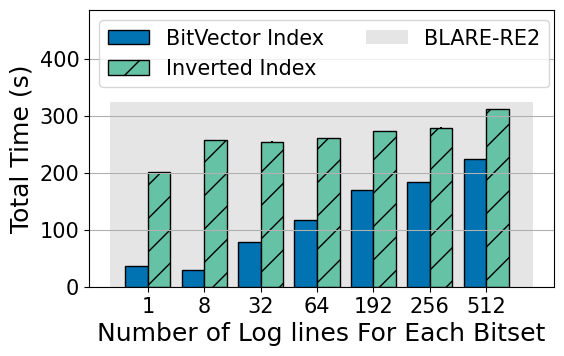

In [29]:
plot_dict= {
    'col_y1': 'Bitvec_Time_Mean(s)',
    'col_err1': 'Bitvec_Time_SE(s)',
    'col_y2': 'Inverted_Time_Mean(s)',
    'col_err2': 'Inverted_Time_SE(s)',
    'ylabel': 'Total Time (s)',
    'title': f'{TARGET_INDEX_NUM} Bigram Filter Runtime'
}
df = overall_df[overall_df['Num_Indexed'] == TARGET_INDEX_NUM]
colors = ['#0173b2', '#66c2a5']
plot_bar_with_err2(df, plot_dict, colors, 'black', fname_prefix='SearchTime', log_scale=False, baseline=True)

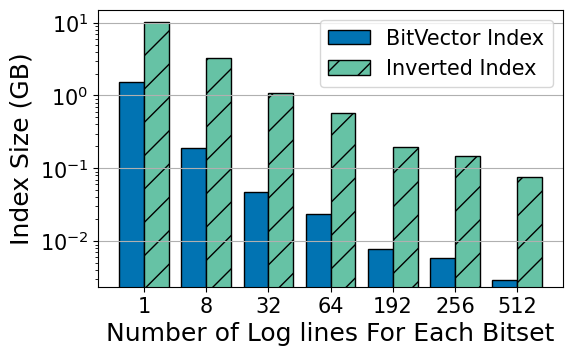

In [30]:
plot_dict= {
    'col_y1': 'Bit_Index_Size(GB)',
    'col_err1': None, #'Bit_Index_Building_Time_SE(s)',
    'col_y2': 'Inverted_Index_Size(GB)',
    'col_err2': None, #'Bit_Index_Building_Time_SE(s)',
    'ylabel': 'Index Size (GB)',
    'title': f'{TARGET_INDEX_NUM} Bigram Index Size'
}
df = overall_df[overall_df['Num_Indexed'] == TARGET_INDEX_NUM]
colors = ['#0173b2', '#66c2a5']

plot_bar_with_err2(df, plot_dict, colors, 'black', fname_prefix='IndexSize', log_scale=True, baseline=False)

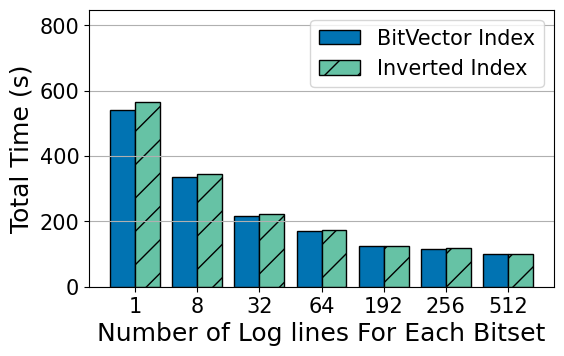

In [31]:
plot_dict= {
    'col_y1': 'Bit_Index_Building_Time_Mean(s)',
    'col_err1': None, #'Bit_Index_Building_Time_SE(s)',
    'col_y2': 'Inverted_Index_Building_Time_Mean(s)',
    'col_err2': None, #'Bit_Index_Building_Time_SE(s)',
    'ylabel': 'Total Time (s)',
    'title': f'{TARGET_INDEX_NUM} Bigram Index Building Time'
}
df = overall_df[overall_df['Num_Indexed'] == TARGET_INDEX_NUM]
colors = ['#0173b2', '#66c2a5']
plot_bar_with_err2(df, plot_dict, colors, 'black', fname_prefix='IndexBuilding', log_scale=False, baseline=False)